In [2]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

%matplotlib inline

Equation
===

The system is governed by the following equation

$$ \dddot{y} + 2.14\ddot{y} + 9.276\dot{y} + 4.228y = 4.228x $$

In [3]:
def model(y_cap, t, params):
    """
        Given a vector <y, y1, y2> returns <y1, y2, y3> according to equation
        above.
    """
    y, y1, y2 = y_cap # y, dy/dt, d2y/dt2
    x = params

    y3 = -2.14*y2 - 9.276*y1 - 4.228*y + 4.228*x
    dy_cap = y1, y2, y3

    return dy_cap

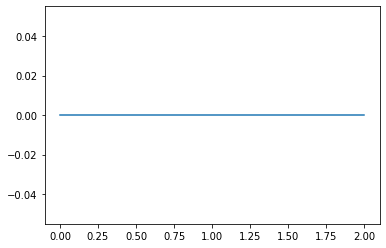

In [10]:
t = np.linspace(0, 1000, num=1000)
params = 2 # let x = 2
y_cap = odeint(model, (0, 0, 0), t, args=(params, ))

plt.plot(y_cap[0]) # Constant input system does not produce anything

In [5]:
class PIDController:
    """
        v = Final output of plant
        u = Input signal to the plant
    """
    def __init__(self, Ki, Kp, Kd, dt, initial_control_var, set_point):
        self.params = (Ki, Kp, Kd)

        self.sum_error = 0
        self.dt = dt

        self.prev_v = initial_control_var
        self.set_point = set_point

    def set_set_point(self, sp):
        self.set_point = sp

    def set_k_constants(Ki, Kp, Kd):
        self.params = (Ki, Kp, Kd)

    def get_control_signal(self, v):
        """
            Given the latest measurement of v(t) we obtain new u(t)
        """
        Ki, Kp, Kd = self.params
        dt = self.dt
        
        error = self.set_point - v
        self.sum_error += error*dt
        derror = (v - self.prev_v)/dt
        
        u = Kp*error + Ki*self.sum_error + Kd*derror

        self.prev_v = v
        
        return u

Simulation
---

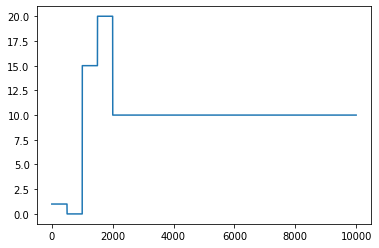

In [6]:
t = np.linspace(0, 1000, num=10000)
delta_t = t[1]-t[0]

SP = np.ones(t.shape[0])
SP[500: 1000] = 0
SP[1000: 1500] = 15
SP[1500: 2000] = 20
SP[2000: ] = 10

plt.plot(SP)

Gain schedule
---

In [7]:
controller = PIDController(Ki=0.1, Kp=1.5, Kd=0, dt=delta_t, initial_control_var=0, set_point=SP[0])

y_caps = [(0, 0, 0)] # initialize with initial values of y_cap
u = np.zeros_like(t)

for i in range(len(t)-1):
    cur_y = y_caps[-1][0]

    u[i+1] = controller.get_control_signal(cur_y) # Get next u from current y
    y_cap_solved = odeint(model, y_caps[i], t[i:i+2], args=(u[i+1], ))[-1]

    y_caps.append(y_cap_solved)

    controller.set_set_point(SP[i])
    controller.set_k_constants()

In [8]:
y_caps = np.array(y_caps)

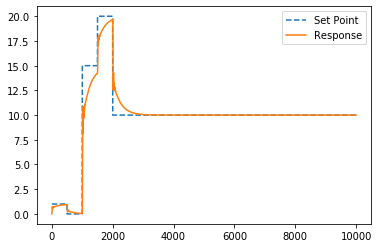

In [9]:
plt.plot(SP, linestyle='dashed', label="Set Point")
plt.plot(y_caps[:, 0], label="Response")
plt.legend()

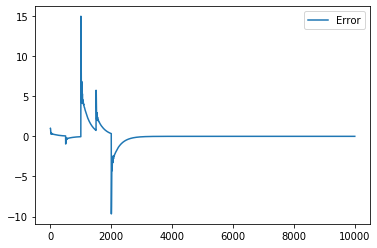

In [11]:
plt.plot(SP-y_caps[:, 0], label="Error")
plt.legend()